In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math

In [4]:
def D(p, z):
    z = z.detach() # we don't backpropagate here
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return -(p*z).sum(dim=1).mean()

In [5]:
class ProjectionMLP(nn.Module):
    """Projection MLP f
    NOTE: According to paper, 2 layer projection MLP is used for CIFAR-10
    """
    def __init__(self, in_features, h1_features, h2_features, out_features):
        super(ProjectionMLP, self).__init__()
        self.l1 = nn.Sequential(
            nn.Linear(in_features, h1_features),
            nn.BatchNorm1d(h1_features),
            nn.ReLU(inplace=True)
        )
        self.l2 = nn.Sequential(
            nn.Linear(h1_features, h2_features),
            nn.BatchNorm1d(h2_features),
            nn.ReLU(inplace=True)

        )
        self.l3 = nn.Sequential(
            nn.Linear(h1_features, out_features),
            nn.BatchNorm1d(out_features)
        )

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x

In [6]:
class PredictionMLP(nn.Module):
    """Prediction MLP h"""
    def __init__(self, in_features, hidden_features, out_features):
        super(PredictionMLP, self).__init__()
        self.l1 = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.BatchNorm1d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.l2 = nn.Linear(hidden_features, out_features)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

In [7]:
class SimSiam(nn.Module):
    def __init__(self):
        super(SimSiam, self).__init__()
        backbone = resnet18(weights=True) # TODO: Should weights be pretrained?
        num_ftrs = backbone.fc.in_features
        
        self.model = nn.Sequential(*list(backbone.children())[:-1])
        self.projection = ProjectionMLP(num_ftrs, 2048, 2048, 2048)
        self.prediction = PredictionMLP(2048, 512, 2048)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1) # TODO
        z = self.projection(x)
        p = self.prediction(z)
        return z, p
        

In [8]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
augmentation = [
    transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=TwoCropsTransform(transforms.Compose(augmentation)))
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))

batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                            shuffle=True, num_workers=2, pin_memory=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
2


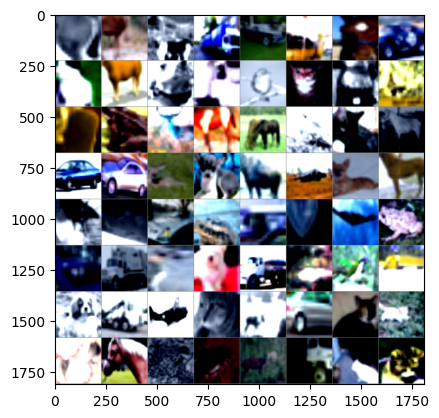

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


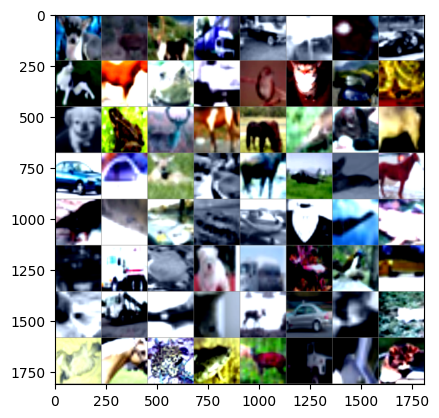

In [10]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)    

print(images[0].shape)
print(images[1].shape)
print(len(images))

imshow(torchvision.utils.make_grid(images[0]))
imshow(torchvision.utils.make_grid(images[1]))


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = SimSiam()
model = model.to(device)

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0005)

In [14]:
# for epoch in range(10):  # loop over the dataset multiple times
#     epoch_loss = 0.0
#     running_loss = 0.0
#     for i, data in enumerate(trainloader):            
#         # get the inputs; data is a list of [inputs, labels]
#         # inputs, labels = data
#         images, labels = data[0], data[1].to(device)
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # get the two views (with random augmentations):
#         x1 = images[0].to(device)
#         x2 = images[1].to(device)
        
#         # forward + backward + optimize
#         z1, p1 = model(x1)
#         z2, p2 = model(x2)
#         #loss = criterion(outputs, labels)
#         loss = D(p1, z2)/2 + D(p2, z1)/2
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         epoch_loss += loss.item()
#         if i % 100 == 99:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
#             running_loss = 0.0
#     print("epoch loss = ", epoch_loss/len(trainloader))
# print('Finished Training')

In [15]:
PATH = './simsiam.pth'

# save model
# torch.save(model.state_dict(), PATH)

# load trained model
model = SimSiam()
PATH = "models/simsiam.pth"
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [14]:
# # knn test accuracy

# with torch.no_grad():
#     true_predicted = 0
#     total_predicted = 0
#     for i, data in enumerate(testloader):  
#         images, labels = data[0].to(device), data[1].to(device)
#         z, _ = model(images) # f(z)
#         for j in range(len(images)): # iterate through images
#             dist = torch.norm(z[j] - z, dim=1, p=None)
#             knn = dist.topk(4, largest=False) # NOTE: Remove first one, it's distance to itself
#             # get index
#             indices = knn.indices[1:]
#             # get label of element at index
#             classes = labels[indices]
#             # maximum vote
#             predicted_label, _ = torch.mode(classes)
#             true_label = labels[j]
#             if true_label == predicted_label:
#                 true_predicted += 1
#             total_predicted += 1
#         print("current accuracy: ", true_predicted/total_predicted)

# print("accuracy = ", true_predicted/total_predicted)

In [17]:
def calculate_nn(image_id):
  """takes in image_id of testset and calculates distances to all images"""
  image, label = testset[image_id]
  image = image.view(1,3,32,32)
  z, _ = model(image) # f(z)
  nn_dict = {}
  tracker = 0
  with torch.no_grad():
      for i in range(len(testset)):  
        test_image, label = testset[i]
        test_image = test_image.view(1,3,32,32)
        z_test, _ = model(test_image) # f(z)
        dist = torch.norm(z_test - z, dim=1, p=None)
        nn_dict[f"{tracker}"] = dist.float()
        tracker += 1
  sorted_nn_dict = sorted(nn_dict.items(), key=lambda kv: kv[1], reverse=False)
  return sorted_nn_dict

In [18]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_knn(image_id, k=3):
  """visualizes original image and its k nearest neighbors in the embedding space"""
  sorted_nn_dict = calculate_nn(image_id)
  ls_of_img_tensors = []
  for i in range(k+1):
    id, dist = sorted_nn_dict[i]
    img, label = testset[int(id)]
    ls_of_img_tensors.append(img)
  img_tensor = torch.stack(ls_of_img_tensors)
  imshow(torchvision.utils.make_grid(img_tensor))

In [19]:
def calculate_knn_accuracy(k=3, testset=testset):
    true_predicted = 0
    total_predicted = 0
    distance_memory = np.zeros((len(testset), len(testset))) # use dynamic programming

    with torch.no_grad():
        for i in range(len(testset)):
            curr_image, curr_label = testset[i]
            curr_image = curr_image.view(1,3,32,32)
            z_curr, _ = model(curr_image) # f(z)
            for j in range(len(testset)):
                if distance_memory[i][j] == 0: # fill in memory
                    comp_image, comp_label = testset[j]
                    comp_image = comp_image.view(1,3,32,32)
                    z_comp, _ = model(comp_image) # f(z)
                    dist = torch.norm(z_curr - z_comp, dim=1, p=None)
                    distance_memory[i][j] = dist.float()
                else:
                  dist = distance_memory[i][j]

    return distance_memory

In [20]:
model.eval()

SimSiam(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
visualize_knn(0)

In [ ]:
visualize_knn(15)

# SSL vs Supervised Comparison on 1%/10% of data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # ((mean, mean, mean), (std, std, st))


batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Get only 1% / 10% of data
one_percent = 0.01 * len(trainset)
ten_percent = 0.1  * len(trainset)
trainset_onepercent = torch.utils.data.Subset(trainset, [i for i in range(int(one_percent))])
trainset_tenpercent = torch.utils.data.Subset(trainset, [i for i in range(int(ten_percent))])


trainloader = torch.utils.data.DataLoader(trainset_tenpercent, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Linear Evaluation

### Supervised model

In [ ]:
model = torchvision.models.resnet18(weights=True)

# freeze parameters for linear evaluation
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # 10 output classes

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
# performance on whole testset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

### SimSiam

In [ ]:
model = SimSiam()
PATH = './simsiam.pth'
model.load_state_dict(torch.load(PATH))

for param in model.parameters():
    param.requires_grad = False

classifier = nn.Linear(2048, 10)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
classifier = classifier.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model.eval()
classifier.train()
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        with torch.no_grad():
          z, _ = model(inputs)
        outputs = classifier(z)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
# performance on whole testset
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        z, _ = model(inputs)
        outputs = classifier(z)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# Fine Tuning
### SimSiam vs Supervised Learning on 1% / 10% of data

#### Supervised model

In [ ]:
model = torchvision.models.resnet18(weights=True)

# don't  freeze parameters for linear evaluation
# for param in model.parameters():
#     param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # 10 output classes

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
# performance on whole testset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

### SimSiam